<a href="https://colab.research.google.com/github/rohanp031/Handwritten-Digit-Recognition-with-LeNet5-Model-in-PyTorch/blob/main/Handwritten_Digit_Recognition_with_LeNet5_Model_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O t10k-images.idx3-ubyte https://github.com/rohanp031/Handwritten-Digit-Recognition-with-LeNet5-Model-in-PyTorch/raw/main/MNIST_dataset/t10k-images.idx3-ubyte
!wget -O t10k-labels.idx1-ubyte https://github.com/rohanp031/Handwritten-Digit-Recognition-with-LeNet5-Model-in-PyTorch/raw/main/MNIST_dataset/t10k-labels.idx1-ubyte

--2024-06-04 14:15:00--  https://github.com/rohanp031/Handwritten-Digit-Recognition-with-LeNet5-Model-in-PyTorch/raw/main/MNIST_dataset/t10k-images.idx3-ubyte
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rohanp031/Handwritten-Digit-Recognition-with-LeNet5-Model-in-PyTorch/main/MNIST_dataset/t10k-images.idx3-ubyte [following]
--2024-06-04 14:15:00--  https://raw.githubusercontent.com/rohanp031/Handwritten-Digit-Recognition-with-LeNet5-Model-in-PyTorch/main/MNIST_dataset/t10k-images.idx3-ubyte
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7840016 (7.5M) [application/octet-stream]
Saving to: ‘

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
images = read_idx('t10k-images.idx3-ubyte')
labels = read_idx('t10k-labels.idx1-ubyte')


In [ ]:
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')
print(f'Number of images: {len(images)}')
print(f'Number of labels: {len(labels)}')

Images shape: (10000, 28, 28)
Labels shape: (10000,)
Number of images: 10000
Number of labels: 10000


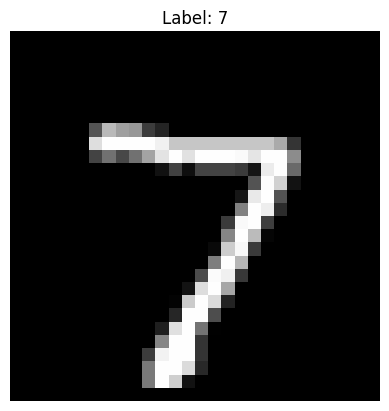

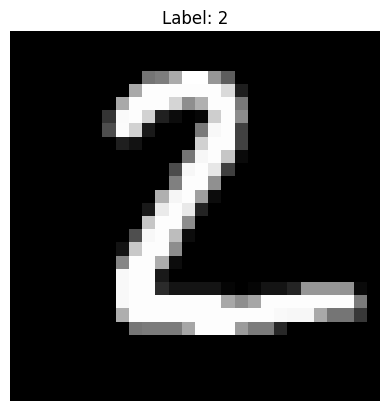

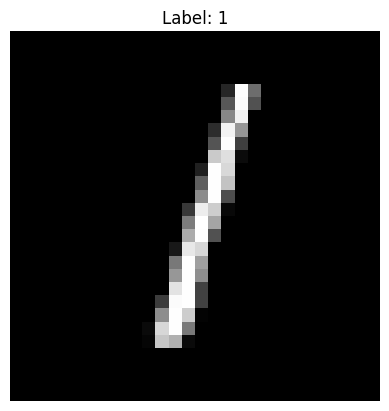

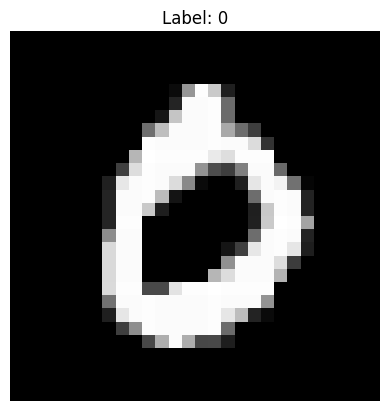

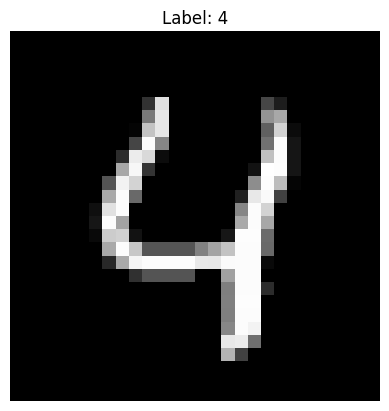

In [ ]:
def display_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

for i in range(5):
    display_image(images[i], labels[i])
